In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import itertools

Набор данных CIFAR10 содержит 60 000 цветных изображений в 10 классах, по 6 000 изображений в каждом классе. Набор данных разделен на 50 000 обучающих изображений и 10 000 тестовых изображений. Классы являются взаимоисключающими, и между ними нет перекрытия.

Установим гиперпараметры моделей и другие глобальные параметры.

In [2]:
batch_size = 32 
num_classes = 10 
epochs = 20
data_augmentation = False

Загружаем данные и разделяем их между обучающим и тестовым наборами.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


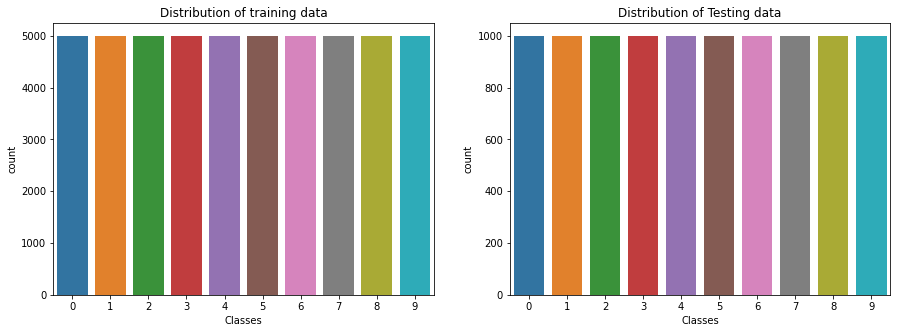

In [4]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

Каждый класс содержит ровно 6000 примеров (5000 для обучения и 1000 для тестирования).

Приведенный выше график очень важен для обучения, например, если бы у нас было всего 1000 образцов метки 1, что будет проблемой, модель столкнется с трудностями при обнаружении метки 1 с «меньшей точностью», так что не все будет хорошо. . Важно знать распределение набора данных по разным классам, потому что от этого зависит качество нашей модели.

Теперь займемся предварительной обработкой.

Выходная переменная имеет 10 возможных значений. Это проблема мультиклассовой классификации. Нужно закодировать эти метки в один горячий вектор

Нормализуем данные

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

На первом этапе сеть изучит 32 сверточных фильтра, каждый из которых имеет размер 3 x 3. Выходной размер такой же, как и у входной формы, поэтому он будет 32 x 32, и активация повторяется, что является простым способом введения нелинейности; за ними следуют еще 32 сверточных фильтра, каждый из которых имеет размер 3 x 3 и активацию также является повторным. После этого у нас есть операция максимального пула с размером пула 2 x 2 и выпадением при 25%.
На следующем этапе глубокого конвейера сеть изучит 64 сверточных фильтра, каждый из которых имеет размер 3 x 3. Выходной размер такой же, как у входной формы, и активация повторяется; за ними следуют еще 64 сверточных фильтра, каждый из которых имеет размер 3 x 3 и активацию также является повторным. После этого у нас есть операция максимального пула с размером пула 2 x 2 и выпадением при 25%.
И заключительный этап в глубоком конвейере - это плотная сеть с 512 устройствами и активацией relu, за которой следует выпадение на 50% и слой softmax с 10 классами на выходе, по одному для каждой категории.

In [6]:
#define the convnet
model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

Обучение модели. Перед тем, как подготовить сеть к обучению, нужно обязательно добавить:
Функцию потерь: для измерения качества сети
Оптимизатор: для обновления сети, когда она видит больше данных, и уменьшения потерь
Метрики: для мониторинга производительности сети

In [7]:

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [8]:
history = None  
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        zca_epsilon=1e-06, 
        rotation_range=0,  
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0.,  
        channel_shift_range=0., 
        fill_mode='nearest',
        cval=0., 
        horizontal_flip=True,  
        vertical_flip=False,  
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

    datagen.fit(x_train)

    history = model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test, y_test),
                                    workers=4)

Not using data augmentation.
Epoch 1/20
1563/1563 [==============================] - 245s 156ms/step - loss: 2.0310 - accuracy: 0.2445 - val_loss: 1.5369 - val_accuracy: 0.4497
Epoch 2/20
1563/1563 [==============================] - 248s 159ms/step - loss: 1.5401 - accuracy: 0.4393 - val_loss: 1.4751 - val_accuracy: 0.4766
Epoch 3/20
1563/1563 [==============================] - 244s 156ms/step - loss: 1.3897 - accuracy: 0.4962 - val_loss: 1.3181 - val_accuracy: 0.5337
Epoch 4/20
1563/1563 [==============================] - 245s 157ms/step - loss: 1.2842 - accuracy: 0.5441 - val_loss: 1.1621 - val_accuracy: 0.5897
Epoch 5/20
1563/1563 [==============================] - 245s 157ms/step - loss: 1.2034 - accuracy: 0.5746 - val_loss: 1.1355 - val_accuracy: 0.6063
Epoch 6/20
1563/1563 [==============================] - 243s 155ms/step - loss: 1.1361 - accuracy: 0.5995 - val_loss: 1.0530 - val_accuracy: 0.6352
Epoch 7/20
1563/1563 [==============================] - 244s 156ms/step - loss: 1.0

Посмотрим на процесс обучения и проверки с помощью визуализации

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


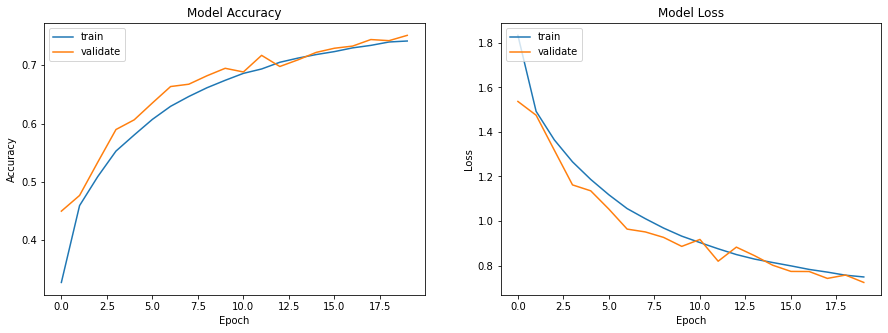

In [9]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()


print(history.history.keys())

plotmodelhistory(history)

После 60 эпох точность нашей модели практически не повышается.

Оценка обученной модели и прогноз

In [10]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(x_test)

313/313 [==============================] - 11s 36ms/step - loss: 0.7239 - accuracy: 0.7512
Test loss: 0.7239095568656921
Test accuracy: 0.7512000203132629


Строим матрицу ошибок

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

In [ ]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = x_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

Строим метрики качества

In [13]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78      1000
           1       0.93      0.82      0.87      1000
           2       0.67      0.58      0.62      1000
           3       0.58      0.56      0.57      1000
           4       0.64      0.78      0.70      1000
           5       0.66      0.65      0.65      1000
           6       0.76      0.86      0.81      1000
           7       0.82      0.79      0.80      1000
           8       0.87      0.85      0.86      1000
           9       0.83      0.86      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Датасет CIFAR-100 с классами bridge, castle, house, road, skyscrape

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras.datasets import cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

In [15]:
height = 224
width = 224
channels = 3
input_shape = (height, width, channels)
n_classes = 100

# parameters for optimizers
lr = 1e-3

# Parameters for training
epochs = 25
batch_size = 8

# parameters for callback functions
es_patience = 10
rlrop_patience = 5
decay_rate = 0.5

Cifar-100 содержит 50 000 данных обучения и 10 000 данных тестирования, каждое из которых представляет собой 32 x 32 x 3 изображения с 1 классом из 100 классов.

In [16]:
(X, y), (X_test, y_test) = cifar100.load_data()

print("The shape of X_train : ", X.shape)
print("The shape of X_test : ", X_test.shape)

fine_label_list =  ['bridge', 'castle', 'house', 'road', 'skyscraper']

169009152/169001437 [==============================] - 4s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)
169009152/169001437 [==============================] - 4s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)
169009152/169001437 [==============================] - 4s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)
169009152/169001437 [==============================] - 4s 0us/step
The shape of X_train :  (50000, 32, 32, 3)
The shape of X_test :  (10000, 32, 32, 3)
